# CRISPR gRNA On-Target Efficiency Prediction
## Complete Machine Learning Pipeline

**Team:** Dedeepya Chaalika Chukka (1002231599), Puli Joshith Reddy (1002231617), Mokshagna (1002198292)

This notebook contains the complete pipeline from data ingestion to model training and evaluation.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import joblib


## 2. Data Download and Generation

In [ ]:
def download_doench_data():
    print("Downloading Doench 2016 CRISPR dataset...")
    urls = [
        "https://raw.githubusercontent.com/MicrosoftResearch/Azimuth/master/azimuth/data/FC_plus_RES_withPredictions.csv",
        "https://media.nature.com/original/nature-assets/nbt/journal/v34/n2/extref/nbt.3437-S4.xlsx",
    ]
    for i, url in enumerate(urls):
        try:
            print(f"Trying source {i+1}...")
            if url.endswith('.xlsx'):
                data = pd.read_excel(url)
            else:
                response = requests.get(url, timeout=30)
                response.raise_for_status()
                data = pd.read_csv(StringIO(response.text))
            print(f"Downloaded {len(data)} gRNA sequences from source {i+1}")
            return data, i+1
        except Exception as e:
            print(f"  Failed: {e}")
            continue
    print("All sources failed. Creating synthetic dataset...")



raw_data, source_id = download_doench_data()
print(f"\nDataset shape: {raw_data.shape}")
raw_data.head()

Trying source 1...
Downloaded 5310 gRNA sequences from source 1

Dataset shape: (5310, 9)


,Unnamed: 0,30mer,Target gene,Percent Peptide,Amino Acid Cut position,score_drug_gene_rank,score_drug_gene_threshold,drug,predictions
0,0,CAGAAAAAAAAACACTGCAACAAGAGGGTA,CD5,72.87,360.0,0.083682,0,nodrug,0.544412
1,1,TTTTAAAAAACCTACCGTAAACTCGGGTCA,NF1,65.80,1868.0,0.868207,1,PLX_2uM,0.617512
2,2,TCAGAAAAAGCAGCGTCAGTGGATTGGCCC,CD5,84.21,416.0,0.184100,0,nodrug,0.476232
3,3,AATAAAAAATAGGATTCCCAGCTTTGGAAG,NF1,56.39,1601.0,0.432065,0,PLX_2uM,0.459882
4,4,GATGAAAAATATGTAAACAGCATTTGGGAC,CUL3,4.30,33.0,0.149351,0,PLX_2uM,0.290841


## 3. Feature Extraction

In [4]:
def extract_sequence_features(seq):
    features = {}
    if len(seq) >= 24:
        guide = seq[4:24]
    else:
        guide = seq[:20] if len(seq) >= 20 else seq

    gc_count = guide.count('G') + guide.count('C')
    features['gc_content'] = gc_count / len(guide) if len(guide) > 0 else 0

    for i, nt in enumerate(guide[:20]):
        for base in ['A', 'C', 'G', 'T']:
            features[f'pos_{i}_{base}'] = 1 if nt == base else 0

    kmers_2 = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT',
               'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    for kmer in kmers_2:
        features[f'kmer2_{kmer}'] = guide.count(kmer)

    features['A_count'] = guide.count('A')
    features['C_count'] = guide.count('C')
    features['G_count'] = guide.count('G')
    features['T_count'] = guide.count('T')

    return features

def preprocess_data(df):
    print("Preprocessing data...")

    if '30mer' in df.columns:
        seq_col = '30mer'
        score_col = 'score' if 'score' in df.columns else df.columns[-1]
    elif 'sequence' in df.columns:
        seq_col = 'sequence'
        score_col = 'efficiency' if 'efficiency' in df.columns else df.columns[-1]
    elif 'efficiency_score' in df.columns:
        seq_col = '30mer'
        score_col = 'efficiency_score'
    else:
        seq_col = df.columns[0]
        score_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

    print(f"Using sequence column: {seq_col}")
    print(f"Using score column: {score_col}")

    feature_list = []
    for idx, row in df.iterrows():
        if idx % 1000 == 0:
            print(f"Processing sequence {idx}/{len(df)}...")
        try:
            seq = str(row[seq_col])
            if len(seq) < 20:
                continue
            features = extract_sequence_features(seq)
            features['efficiency_score'] = float(row[score_col])
            feature_list.append(features)
        except:
            continue

    feature_df = pd.DataFrame(feature_list)

    if 'efficiency_score' in feature_df.columns:
        min_score = feature_df['efficiency_score'].min()
        max_score = feature_df['efficiency_score'].max()
        if max_score > min_score:
            feature_df['efficiency_score'] = (feature_df['efficiency_score'] - min_score) / (max_score - min_score)

    print(f"Extracted {len(feature_df.columns)-1} features from {len(feature_df)} sequences")
    return feature_df

processed_data = preprocess_data(raw_data)
print(f"\nFinal dataset shape: {processed_data.shape}")
processed_data.head()

Preprocessing data...
Using sequence column: 30mer
Using score column: predictions
Processing sequence 0/5310...
Processing sequence 1000/5310...
Processing sequence 2000/5310...
Processing sequence 3000/5310...
Processing sequence 4000/5310...
Processing sequence 5000/5310...
Extracted 101 features from 5310 sequences

Final dataset shape: (5310, 102)


,gc_content,pos_0_A,pos_0_C,pos_0_G,pos_0_T,pos_1_A,pos_1_C,pos_1_G,pos_1_T,pos_2_A,...,kmer2_GT,kmer2_TA,kmer2_TC,kmer2_TG,kmer2_TT,A_count,C_count,G_count,T_count,efficiency_score
0,0.30,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,13,4,2,1,0.626847
1,0.35,1,0,0,0,1,0,0,0,1,...,1,2,1,0,0,10,6,1,3,0.708581
2,0.45,1,0,0,0,1,0,0,0,1,...,2,0,1,1,0,8,3,6,3,0.550614
3,0.35,1,0,0,0,1,0,0,0,1,...,0,1,1,0,2,8,4,3,5,0.532333
4,0.20,1,0,0,0,1,0,0,0,1,...,1,2,0,1,1,11,2,2,5,0.343326


## 4. Exploratory Data Analysis

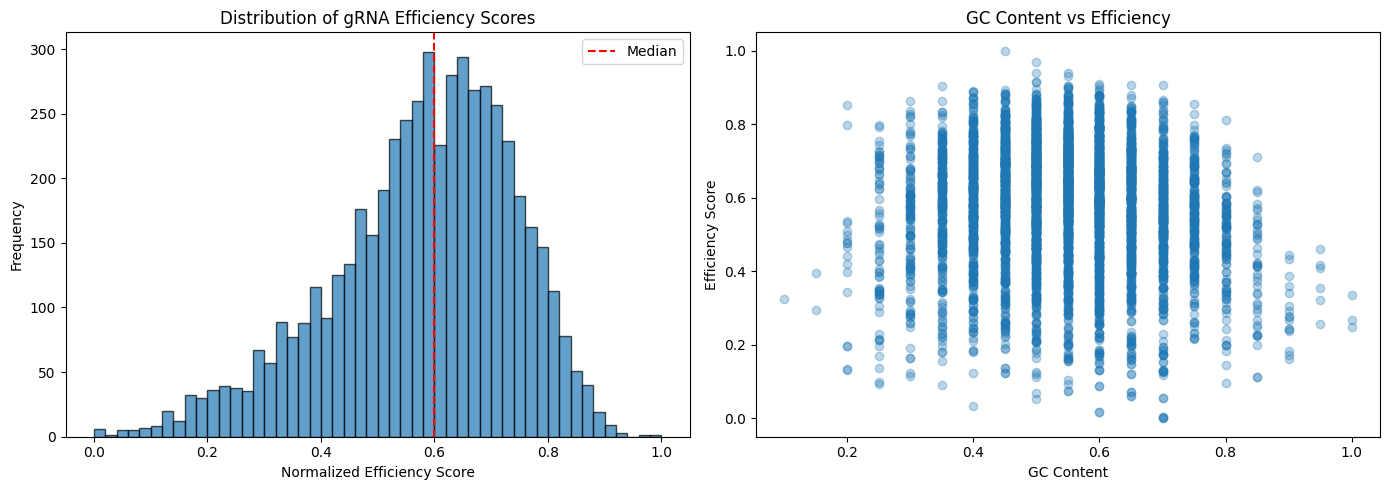

Correlation (GC vs Efficiency): -0.085


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(processed_data['efficiency_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(processed_data['efficiency_score'].median(), color='red', linestyle='--', label='Median')
axes[0].set_xlabel('Normalized Efficiency Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of gRNA Efficiency Scores')
axes[0].legend()

axes[1].scatter(processed_data['gc_content'], processed_data['efficiency_score'], alpha=0.3)
axes[1].set_xlabel('GC Content')
axes[1].set_ylabel('Efficiency Score')
axes[1].set_title('GC Content vs Efficiency')

plt.tight_layout()
plt.show()

print(f"Correlation (GC vs Efficiency): {processed_data['gc_content'].corr(processed_data['efficiency_score']):.3f}")

## 5. Prepare Data for Modeling

In [6]:
X = processed_data.drop('efficiency_score', axis=1)
y = (processed_data['efficiency_score'] > processed_data['efficiency_score'].median()).astype(int)

print(f"Features shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Features shape: (5310, 101)
Target distribution: {0: 2656, 1: 2654}

Train set: (4248, 101)
Test set: (1062, 101)


## 6. Feature Selection

In [7]:
selector = SelectKBest(f_classif, k=50)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()].tolist()
print(f"Selected {len(selected_features)} features")
print(f"Top 10 features: {selected_features[:10]}")

Selected 50 features
Top 10 features: ['gc_content', 'pos_1_A', 'pos_2_A', 'pos_2_C', 'pos_4_A', 'pos_7_G', 'pos_8_A', 'pos_8_G', 'pos_9_A', 'pos_9_G']


## 7. Feature Scaling

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print("Features scaled")

Features scaled


## 8. Baseline Model Training

In [9]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"{name} ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))

    results[name] = {
        'model': model,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc
    }


Training Logistic Regression...
Logistic Regression ROC-AUC: 0.8531
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       531
           1       0.76      0.77      0.77       531

    accuracy                           0.77      1062
   macro avg       0.77      0.77      0.77      1062
weighted avg       0.77      0.77      0.77      1062


Training Random Forest...
Random Forest ROC-AUC: 0.9229
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       531
           1       0.84      0.85      0.84       531

    accuracy                           0.84      1062
   macro avg       0.84      0.84      0.84      1062
weighted avg       0.84      0.84      0.84      1062


Training XGBoost...
XGBoost ROC-AUC: 0.9102
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       531
           1       0.85      0.84      0.84       531

    accurac

## 9. ROC Curve Visualization

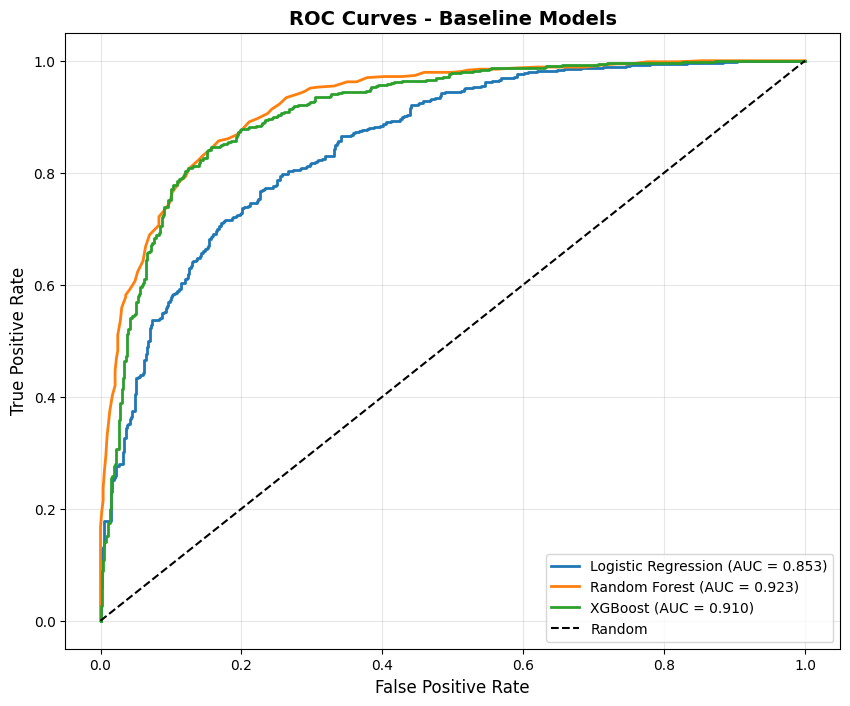

In [10]:
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Baseline Models', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 10. Advanced Feature Engineering

In [11]:
print("Performing correlation analysis...")
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_features = [column for column in upper_triangle.columns
                      if any(upper_triangle[column] > 0.95)]
print(f"Removing {len(high_corr_features)} highly correlated features")

X_decorrelated = X.drop(columns=high_corr_features)
print(f"After correlation filtering: {X_decorrelated.shape}")

Performing correlation analysis...
Removing 0 highly correlated features
After correlation filtering: (5310, 101)


In [12]:
print("Computing mutual information scores...")
mi_scores = mutual_info_classif(X_decorrelated, y, random_state=42)
mi_df = pd.DataFrame({
    'feature': X_decorrelated.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print(f"\nTop 10 features by mutual information:")
print(mi_df.head(10))

top_mi_features = mi_df.head(30)['feature'].tolist()
X_mi_selected = X_decorrelated[top_mi_features]

Computing mutual information scores...

Top 10 features by mutual information:
     feature  mi_score
97   A_count  0.047947
79  pos_19_G  0.046750
78  pos_19_C  0.033246
80  pos_19_T  0.024105
82  kmer2_AC  0.022517
72  pos_17_T  0.021680
99   G_count  0.020012
35   pos_8_G  0.019718
85  kmer2_CA  0.019466
62  pos_15_C  0.018827


In [13]:
print("Creating polynomial features...")
top_10_features = mi_df.head(10)['feature'].tolist()
X_top10 = X_decorrelated[top_10_features]

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_top10)
poly_feature_names = poly.get_feature_names_out(top_10_features)

print(f"Polynomial features created: {X_poly.shape[1]}")

X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X_mi_selected.index)
X_combined = pd.concat([X_mi_selected, X_poly_df], axis=1)
X_combined = X_combined.loc[:, ~X_combined.columns.duplicated()]

print(f"Combined feature set: {X_combined.shape}")

Creating polynomial features...
Polynomial features created: 55
Combined feature set: (5310, 75)


In [14]:
print("Final feature selection...")
mi_scores_combined = mutual_info_classif(X_combined, y, random_state=42)
mi_indices = np.argsort(mi_scores_combined)[::-1][:50]
X_final = X_combined.iloc[:, mi_indices]

print(f"Final feature set: {X_final.shape}")
print(f"\nTop 10 final features:")
for i, idx in enumerate(mi_indices[:10]):
    print(f"  {X_combined.columns[idx]}: {mi_scores_combined[idx]:.4f}")

Final feature selection...
Final feature set: (5310, 50)

Top 10 final features:
  pos_19_G G_count: 0.0523
  pos_19_G: 0.0492
  A_count pos_19_C: 0.0433
  A_count G_count: 0.0418
  A_count pos_19_G: 0.0401
  pos_19_G kmer2_CA: 0.0387
  A_count kmer2_CA: 0.0385
  pos_19_C kmer2_CA: 0.0360
  A_count: 0.0345
  pos_19_G pos_15_C: 0.0331


## 11. Advanced Model Training with Grid Search

In [15]:
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

scaler_adv = StandardScaler()
X_train_adv_scaled = scaler_adv.fit_transform(X_train_adv)
X_test_adv_scaled = scaler_adv.transform(X_test_adv)

print(f"Advanced train set: {X_train_adv_scaled.shape}")
print(f"Advanced test set: {X_test_adv_scaled.shape}")

Advanced train set: (4248, 50)
Advanced test set: (1062, 50)


In [16]:
import warnings
warnings.filterwarnings("ignore")

models_and_params = {


    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'Support Vector Machine': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 0.01, 0.1]
        }
    },
    'Neural Network': {
        'model': MLPClassifier(random_state=42, max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [20, 30],
            'min_samples_split': [2, 5]
        }
    }
}

advanced_results = {}
best_overall_score = 0
best_overall_model = None
best_overall_name = None

for name, config in models_and_params.items():
    print(f"\nGrid Search: {name}")
    print("="*60)

    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_adv_scaled, y_train_adv)

    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test_adv_scaled)[:, 1]
    y_pred = best_model.predict(X_test_adv_scaled)

    test_score = roc_auc_score(y_test_adv, y_pred_proba)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    print(f"Test ROC-AUC: {test_score:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test_adv, y_pred))

    advanced_results[name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'test_score': test_score,
        'y_pred_proba': y_pred_proba
    }

    if test_score > best_overall_score:
        best_overall_score = test_score
        best_overall_model = best_model
        best_overall_name = name


Grid Search: XGBoost
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV score: 0.8370
Test ROC-AUC: 0.8661

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       531
           1       0.78      0.81      0.79       531

    accuracy                           0.79      1062
   macro avg       0.79      0.79      0.79      1062
weighted avg       0.79      0.79      0.79      1062


Grid Search: K-Nearest Neighbors
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best CV score: 0.8341
Test ROC-AUC: 0.8754

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       531
           1       0.78      0.80      0.79       531

    accuracy       

## 12. Final Results and Comparison

In [18]:
print("="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(f"\nBEST MODEL: {best_overall_name}")
print(f"   Test ROC-AUC: {best_overall_score:.4f}")
print(f"   CV ROC-AUC: {advanced_results[best_overall_name]['cv_score']:.4f}")
print(f"   Best Parameters: {advanced_results[best_overall_name]['best_params']}")

print(f"\nALL MODEL SCORES:")
results_df = pd.DataFrame({
    'Model': list(advanced_results.keys()),
    'CV_Score': [advanced_results[name]['cv_score'] for name in advanced_results.keys()],
    'Test_Score': [advanced_results[name]['test_score'] for name in advanced_results.keys()]
}).sort_values('Test_Score', ascending=False)

print(results_df.to_string(index=False))

FINAL RESULTS SUMMARY

BEST MODEL: Random Forest
   Test ROC-AUC: 0.8893
   CV ROC-AUC: 0.8519
   Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

ALL MODEL SCORES:
                 Model  CV_Score  Test_Score
         Random Forest  0.851866    0.889348
   K-Nearest Neighbors  0.834116    0.875431
               XGBoost  0.836971    0.866141
     Gradient Boosting  0.834455    0.860374
        Neural Network  0.810254    0.833899
Support Vector Machine  0.815313    0.821209


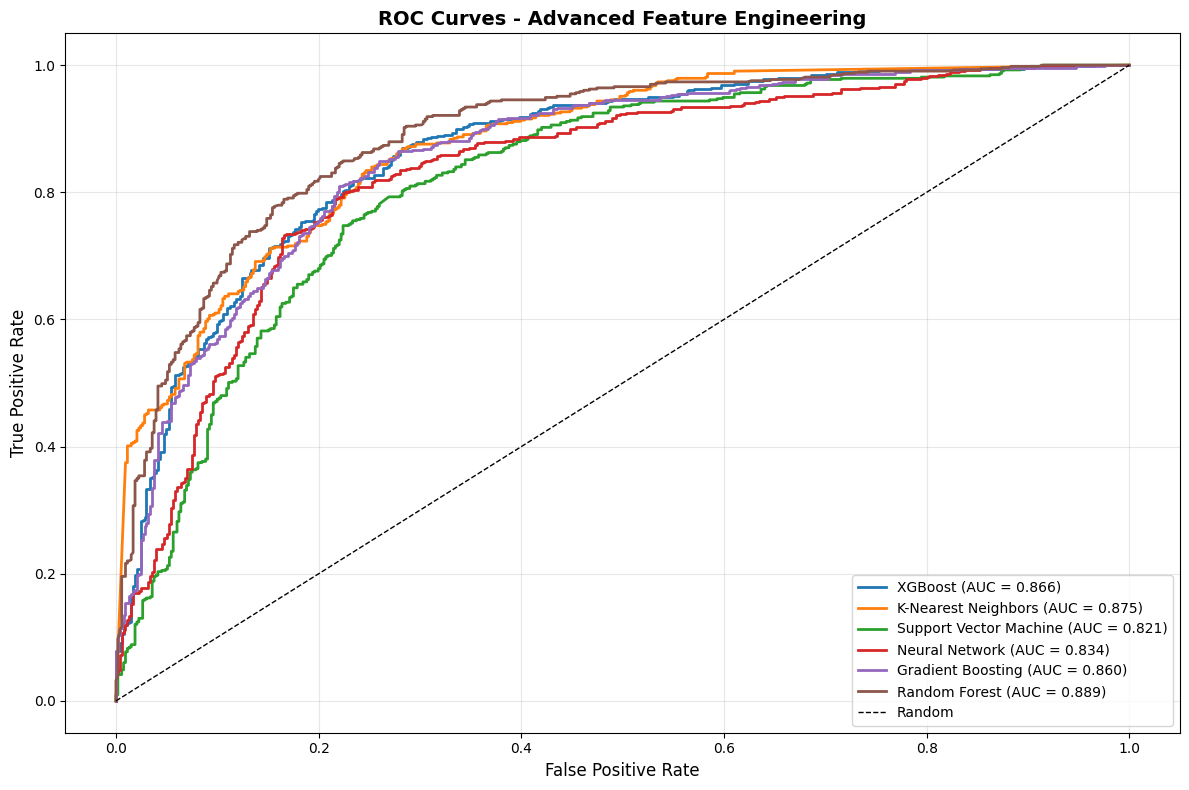

In [19]:
plt.figure(figsize=(12, 8))

for name, result in advanced_results.items():
    fpr, tpr, _ = roc_curve(y_test_adv, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['test_score']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Advanced Feature Engineering', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Model Comparison

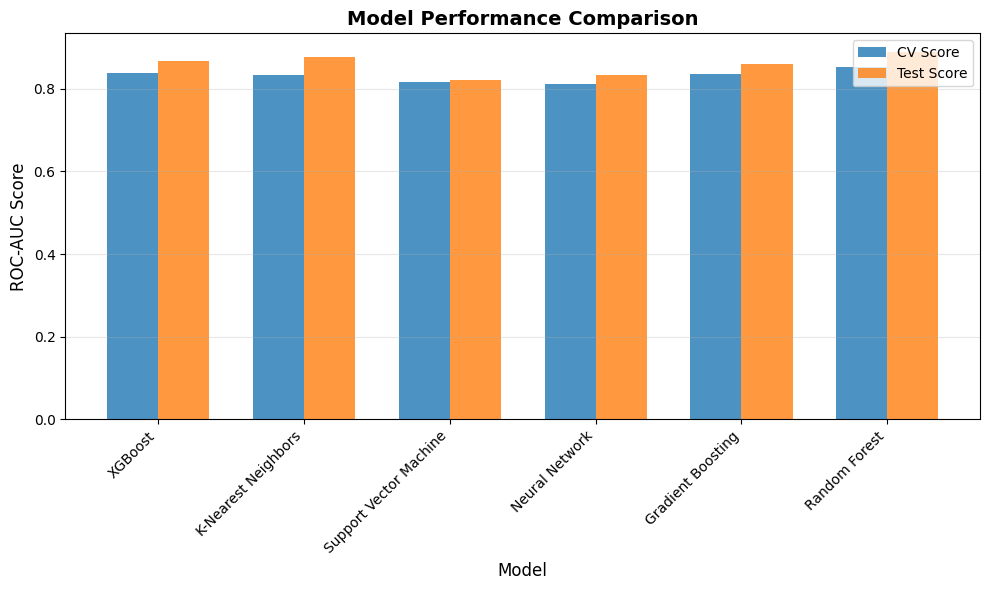

In [20]:
model_names = list(advanced_results.keys())
cv_scores = [advanced_results[name]['cv_score'] for name in model_names]
test_scores = [advanced_results[name]['test_score'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, cv_scores, width, label='CV Score', alpha=0.8)
ax.bar(x + width/2, test_scores, width, label='Test Score', alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('ROC-AUC Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 14. Save Models

In [22]:
joblib.dump(best_overall_model, './best_advanced_model.pkl')
joblib.dump(scaler_adv, './advanced_scaler.pkl')

print(f"Best model ({best_overall_name}) saved successfully")
print(f"Final Test ROC-AUC: {best_overall_score:.4f}")

Best model (Random Forest) saved successfully
Final Test ROC-AUC: 0.8893
